# 1. GoogLeNet

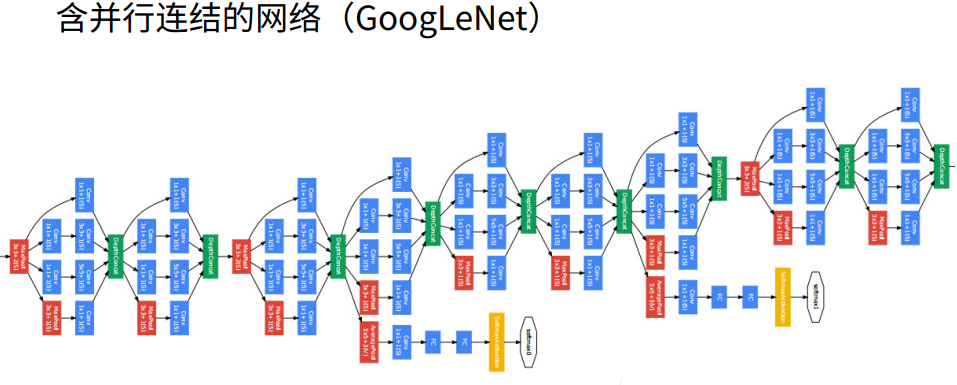

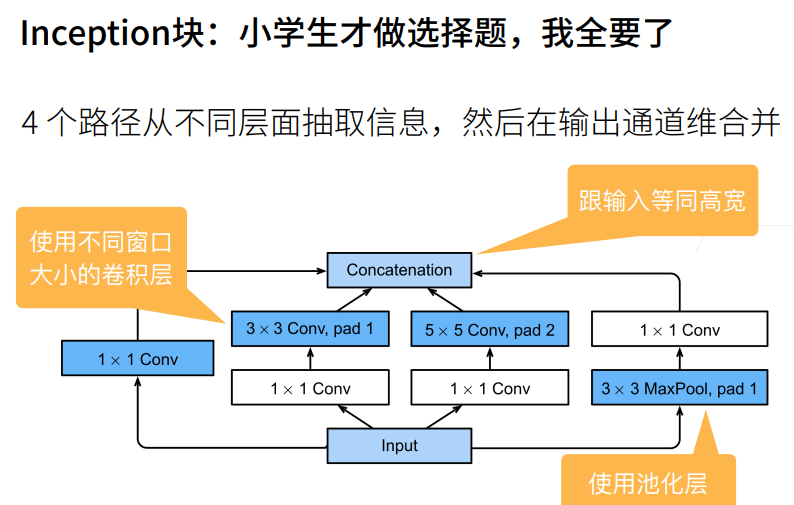

① 白色的卷积用来改变通道数，蓝色的卷积用来抽取信息。

② 最左边一条1X1卷积是用来抽取通道信息，其他的3X3卷积用来抽取空间信息。

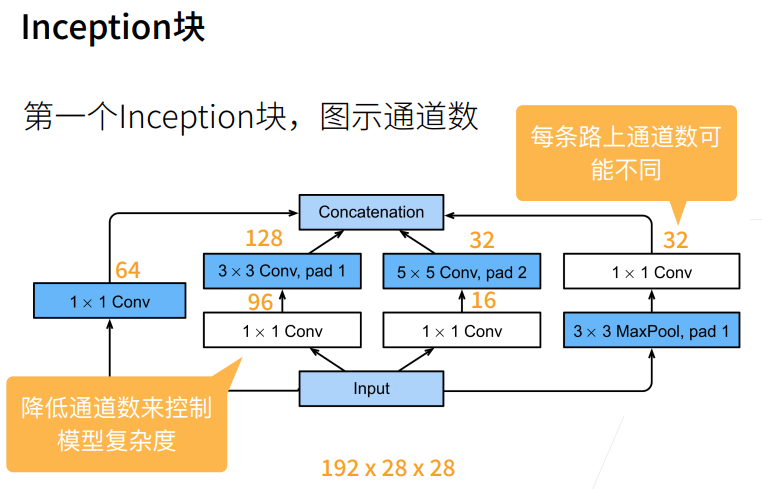

① 输出相同的通道数，5X5比3X3的卷积层参数个数多，3X3比1X1卷积层的参数个数多。

② Inception块使用了大量1X1卷积层，使得参数相对单3X3、5X5卷积层更少。

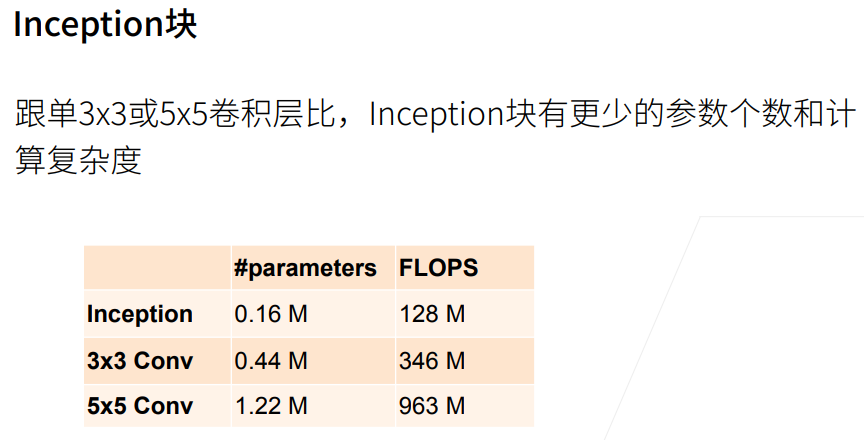

# 2. 总结

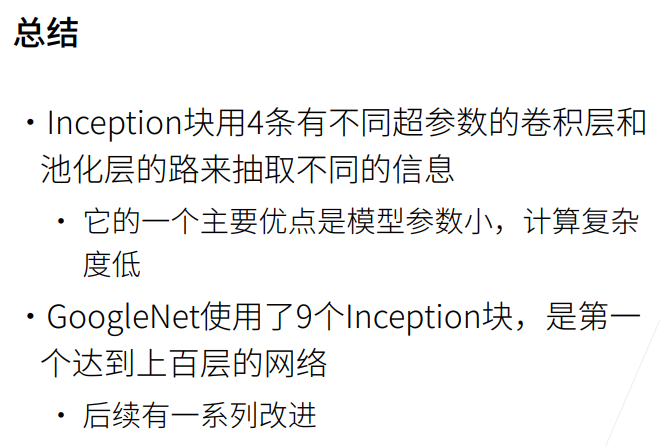

# 1. GoogLeNet 与 Inception 块

GoogLeNet 开启了卷积神经网络设计的**“多路并行”**时代。相比于 VGG 的“无脑堆叠”深度，GoogLeNet 的核心理念是**把网络做“宽”**，并在单个层级内同时使用多种尺寸的卷积核来提取特征。

### 1.1 核心结构：Inception 块 (Inception Block)

GoogLeNet 不再由一层层单一的卷积层堆叠而成，而是由多个 **Inception 块** 串联组成。每个 Inception 块内部包含 **4 条并行的线路**，它们同时处理输入数据，最后将结果在**通道维度**上拼接。

**Inception 块的内部构造（4 条线路）：**

1.  **线路 1（最左）**：**$1\times1$ 卷积层**
    * *作用*：快速提取通道维度的特征，不改变空间尺寸。
2.  **线路 2（中间）**：**$1\times1$ 卷积 $\rightarrow$ $3\times3$ 卷积**
    * *作用*：主力特征提取。先用 $1\times1$ 降维，再用 $3\times3$ 提取常规空间特征。
3.  **线路 3（中间）**：**$1\times1$ 卷积 $\rightarrow$ $5\times5$ 卷积**
    * *作用*：提取更大范围（大感受野）的特征。同样先用 $1\times1$ 降维。
4.  **线路 4（最右）**：**$3\times3$ 最大池化 $\rightarrow$ $1\times1$ 卷积**
    * *作用*：通过池化层降低噪音，增强鲁棒性，最后用 $1\times1$ 调整通道数。

**最终输出**：这 4 条线路计算出的特征图，在**通道维度（Depth）**上进行拼接（Concatenate），作为下一层的输入。

---

### 1.2 关键设计：为什么要有白色的 $1\times1$ 卷积？(Bottleneck Layer)

在 Inception 块中，你会发现在 $3\times3$ 和 $5\times5$ 卷积之前，都先加了一个 $1\times1$ 的卷积。这是 GoogLeNet 最天才的设计——**瓶颈层 (Bottleneck Layer)**。

* **痛点**：直接在高通道数的特征图上做 $5\times5$ 卷积，计算量会极大（参数爆炸）。
* **解决方案**：先用 $1\times1$ 卷积将输入特征图的**通道数压缩（降维）**，就像把一本厚书先写成摘要。
* **效果**：
    * **大幅降低计算量**：让后面的大卷积核在较薄的特征图上工作。
    * **增加非线性**：多加一层卷积就多一次 ReLU 激活，增加网络的表达能力。

### 总结

GoogLeNet 的核心哲学是：**“小孩子才做选择，我全都要。”**
它不再纠结于某一层是用 $1\times1$、$3\times3$ 还是 $5\times5$，而是将它们并联起来同时使用。配合 $1\times1$ 卷积的降维技巧，GoogLeNet 成功做到了在参数量仅为 VGG 的 **1/10** 的情况下，实现了更高的准确率。

# 1. GoogLeNet（使用自定义）

In [4]:
import torch 
# [作用]: 导入 PyTorch 的核心库。
# [详解]: 它提供了最基础的数据结构——张量 (Tensor)。
# 你可以把它理解为“支持 GPU 加速的 NumPy”。如果没有它，就没法定义数据。

from torch import nn
# [作用]: 导入神经网络模块 (Neural Network)。
# [详解]: 这里面装满了搭建网络的“积木”。
# 凡是需要保存权重(Weight)和参数的层，都在这里面。
# 比如: nn.Conv2d (卷积层), nn.Linear (全连接层), nn.MaxPool2d (池化层), nn.CrossEntropyLoss (损失函数)。

from torch.nn import functional as F
# [作用]: 导入函数式接口 (Functional)，并按照惯例简写为 F。
# [详解]: 这里面装的是“纯函数”操作，没有权重，不存状态。
# 比如: F.relu (激活函数), F.softmax (概率归一化)。
# 既然 nn 里也有 ReLU，为什么还要 F 呢？
# - 如果你想把 ReLU 当做一个层加到 nn.Sequential 里，用 nn.ReLU()。
# - 如果你在 forward 函数里只是想简单算一下，用 F.relu() 更方便。


# [语法]: class 类名(父类): 
# [作用]: 定义一个名为 Inception 的自定义层，继承自 nn.Module（PyTorch神经网络模块基类）。
class Inception(nn.Module):
    
    # [语法]: __init__ 是构造函数。**kwargs 是关键字参数解包（接收字典形式的多余参数）。
    # [作用]: 初始化 Inception 块。
    # - in_channels: 输入特征图的厚度。
    # - c1: 线路1的输出通道数。
    # - c2: 线路2的通道数列表（c2[0]是1x1卷积输出，c2[1]是3x3卷积输出）。
    # - c3: 线路3的通道数列表（c3[0]是1x1卷积输出，c3[1]是5x5卷积输出）。
    # - c4: 线路4的输出通道数。
    def __init__(self, in_channels, c1, c2, c3, c4): 
        
        # [语法]: super(当前类, self).__init__() 调用父类构造函数。
        # [作用]: 必须执行！向 PyTorch 系统“注册”这个模块，否则无法管理参数和反向传播。
        super().__init__() 
        
        # ================== 线路 1 (最左边) ==================
        # [语法]: nn.Conv2d(输入通道, 输出通道, 核大小)
        # [作用]: 只使用 1x1 卷积。主要用于改变通道数（通常是降维）或者提取通道间的关联信息。
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        
        # ================== 线路 2 (中间左) ==================
        # [语法]: 访问列表 c2 的第0个元素。
        # [作用]: 线路2的第一步。使用 1x1 卷积作为“瓶颈层”，将输入通道压缩到 c2[0]，减少后续计算量。
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        
        # [语法]: padding=1 (填充)
        # [作用]: 线路2的第二步。3x3 卷积用于提取特征。
        # 关键点：padding=1 配合 kernel_size=3，保证图片的高和宽不变 (H-3+2*1+1 = H)。
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        
        # ================== 线路 3 (中间右) ==================
        # [语法]: 访问列表 c3 的第0个元素。
        # [作用]: 线路3的第一步。同样使用 1x1 卷积进行降维（压缩通道），为后面的大卷积核做准备。
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        
        # [语法]: padding=2
        # [作用]: 线路3的第二步。使用 5x5 大卷积核提取更大范围的特征。
        # 关键点：padding=2 配合 kernel_size=5，保证图片高宽不变 (H-5+2*2+1 = H)。
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        # ================== 线路 4 (最右边) ==================
        # [语法]: nn.MaxPool2d(核大小, 步幅, 填充)
        # [作用]: 线路4的第一步。3x3 最大池化层。
        # 关键点：这里特意设定 stride=1, padding=1，是为了让池化后的图片大小【完全不变】。
        # (通常池化是用来减半尺寸的，但这里不行，为了后面能拼接)。
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        # Default value is kernel_size.
        
        # [语法]: 标准 1x1 卷积
        # [作用]: 线路4的第二步。在池化之后，使用 1x1 卷积来调整最终的输出通道数 (c4)。
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    # [语法]: forward(self, x) 是 PyTorch 的标准前向传播函数名。
    # [作用]: 定义数据 x 进入网络后，是怎么一步步流动的。
    def forward(self, x):
        
        # [语法]: F.relu(层对象(输入数据))。函数式调用激活函数。
        # [作用]: 计算线路1。先过卷积层 self.p1_1，结果再经过 ReLU 激活函数变非线性。
        p1 = F.relu(self.p1_1(x)) 
        
        # [语法]: 嵌套调用函数。先运行最里面的 self.p2_1(x)，再往外层层处理。
        # [作用]: 计算线路2。输入 -> 1x1卷积 -> ReLU -> 3x3卷积 -> ReLU。
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) 
        
        # [语法]: 同上，嵌套调用。
        # [作用]: 计算线路3。输入 -> 1x1卷积 -> ReLU -> 5x5卷积 -> ReLU。
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        
        # [语法]: 注意这里中间没有 F.relu。
        # [作用]: 计算线路4。输入 -> 3x3池化(无激活) -> 1x1卷积 -> ReLU。
        # (池化层本身只是选最大值，不需要激活函数)。
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        
        # [语法]: torch.cat((张量序列), dim=维度索引)
        # [作用]: 在“通道 (Channel)”维度上（dim=1）进行拼接。
        # 假设输入 x 是 (Batch, C_in, H, W)。
        # p1, p2, p3, p4 的 H 和 W 都没变，只有 C (通道数) 不同。
        # 结果会将它们的厚度叠加，输出形状为 (Batch, c1+c2[1]+c3[1]+c4, H, W)。
        return torch.cat((p1, p2, p3, p4), dim=1)

In [10]:
# ==========================================
# b1: 第一模块 - "车头" (The Stem)
# ==========================================
# [作用]: 快速降低图片分辨率。
# 原始图片很大 (224x224)，为了节省计算资源，先用大卷积核和大步幅，
# 迅速把图片尺寸缩小，但把通道数做厚。
b1 = nn.Sequential(
    # [语法]: kernel_size=7 (大核), stride=2 (步幅2), padding=3
    # [计算]: (224 - 7 + 2*3)/2 + 1 = 112。图片尺寸直接减半。
    # 输入通道 1 (假设是Fashion-MNIST灰度图)，输出 64。
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    
    # [作用]: 激活 + 最大池化
    nn.ReLU(),
    
    # [语法]: kernel_size=3, stride=2, padding=1
    # [计算]: (112 - 3 + 2*1)/2 + 1 = 56。图片尺寸再次减半。
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
) 

# ==========================================
# b2: 第二模块 - 特征提取过渡
# ==========================================
# [作用]: 在进入 Inception 块之前，进一步提取特征并调整维度。
b2 = nn.Sequential(
    # [语法]: 1x1 卷积。这里主要起到非线性变换的作用，通道数没变 (64->64)。
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    
    # [语法]: 3x3 卷积。把通道数翻了3倍 (64 -> 192)。
    # padding=1 保证高宽不变。
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    
    # [作用]: 池化层。
    # [计算]: (56 - 3 + 2*1)/2 + 1 = 28。尺寸再次减半，变成 28x28。
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# ==========================================
# b3: 第三模块 - Inception 块的开始
# ==========================================
# [作用]: 开始并行提取特征。这里串联了 2 个 Inception 块。
b3 = nn.Sequential(
    # [语法]: Inception(输入, c1, (c2_1, c2_2), (c3_1, c3_2), c4)
    # 这里的参数对应我们刚才定义的 Inception 类：
    # - 输入 192: 承接 b2 的输出。
    # - c1=64: 线路1输出。
    # - (96, 128): 线路2先压缩到96，再卷出128。
    # - (16, 32): 线路3先压缩到16，再卷出32。
    # - c4=32: 线路4输出。
    # [输出通道]: 64+128+32+32 = 256。
    Inception(192, 64, (96, 128), (16, 32), 32),
    
    # [作用]: 第二个 Inception 块，通道数进一步增加到 480。
    Inception(256, 128, (128, 192), (32, 96), 64),
    
    # [作用]: 池化层。
    # [计算]: 28x28 -> 14x14。
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# ==========================================
# b4: 第四模块 - 加宽加深 (最肥的一段)
# ==========================================
# [作用]: 连续堆叠 5 个 Inception 块，网络变得很深。
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    
    # [注意]: 最后一个块输出通道变成了 832 (256+320+128+128)。
    Inception(528, 256, (160, 320), (32, 128), 128),
    
    # [作用]: 池化层。
    # [计算]: 14x14 -> 7x7。
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# ==========================================
# b5: 第五模块 - 收尾与全局平均池化
# ==========================================
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    
    # [重点]: 最后一个 Inception 块。
    # 输出通道数 = 384 + 384 + 128 + 128 = 1024。
    Inception(832, 384, (192, 384), (48, 128), 128),
    
    # [语法]: nn.AdaptiveAvgPool2d((1,1))
    # [作用]: 全局平均池化 (Global Average Pooling)。
    # 不管前面输入是 7x7 还是 100x100，强行把每个通道平均成 1x1 的一个点。
    # 结果形状: (Batch, 1024, 1, 1)。
    # 这一步极大减少了参数量 (替代了 VGG 那个巨大的全连接层)。
    nn.AdaptiveAvgPool2d((1, 1)),
    
    # [语法]: 展平。变成 (Batch, 1024)。
    nn.Flatten()
)

# ==========================================
# 组装最终网络
# ==========================================
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    # [语法]: nn.Linear(1024, 10)
    # [作用]: 最后的分类器。
    # 输入 1024 是 b5 最后一个 Inception 块计算出来的总通道数。
    # 输出 10 是分类类别数 (如 Fashion-MNIST 有 10 类)。
    nn.Linear(1024, 10)
)

① 在实际的项目当中，我们往往预先只知道的是输入数据和输出数据的大小，而不知道核与步长的大小。

② 我们可以手动计算核的大小和步长的值。而自适应（Adaptive）能让我们从这样的计算当中解脱出来，只要我们给定输入数据和输出数据的大小，自适应算法能够自动帮助我们计算核的大小和每次移动的步长。

③ 相当于我们对核说，我已经给你输入和输出的数据了，你自己适应去吧。你要长多大，你每次要走多远，都由你自己决定，总之最后你的输出符合我的要求就行了。

④ 比如我们给定输入数据的尺寸是9， 输出数据的尺寸是3，那么自适应算法就能自动帮我们计算出，核的大小是3，每次移动的步长也是3，然后依据这些数据，帮我们创建好池化层。

In [9]:
# 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96
X = torch.rand(size=(1,1,96,96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
